In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import os
import seaborn as sns
import datetime
from time import sleep
import scipy.signal as signal 
import sys
sys.path.append('../../dsmuc/')
from dsmuc.custom import detect_peaks
from collections import Counter
sns.set(style="darkgrid")
from models import RNN_classifier,KerasClassifier


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_class_weights(y):
    y = np.asarray(y)
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y.reshape(y.shape[0],))
                                               ,y.reshape(y.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y.reshape(y.shape[0],)),class_weight)}


In [3]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [4]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

In [11]:
df = pd.read_csv("/home/ahmet/notebooks/data/G9_data/processed.csv")
df.dropna(axis=0, how='any', inplace=True)

In [12]:
df.head()

,CorAccXAccY_corr,CorAccXAccZ_corr,CorAccYAccZ_corr,CorGyroXGyroY_corr,CorGyroXGyroZ_corr,CorGyroYGyroZ_corr,accX_aoa,accX_apf,accX_ate,accX_max,...,gyroZ_ate,gyroZ_max,gyroZ_mean,gyroZ_min,gyroZ_minmax,gyroZ_rms,gyroZ_std,label,start,subject_id
0,-0.191494,-0.018550,-0.291556,0.727880,0.461031,0.569434,-6.158093,0.043011,24.333333,-6.009446,...,40.000000,0.017993,0.000428,-0.018226,0.036219,0.007781,0.007769,5.0,2018-01-16 06:30:12.029,15.0
2,0.346551,-0.330945,-0.692002,-0.124647,0.323075,0.331159,-9.611379,0.040000,29.000000,-9.457097,...,24.333333,0.056933,0.000213,-0.028820,0.085754,0.013421,0.013419,5.0,2018-01-16 04:35:14.010,14.0
4,-0.163335,-0.209158,-0.039511,0.581457,-0.036526,-0.345909,-9.551191,0.038835,30.333333,-9.270349,...,37.500000,0.191847,-0.004006,-0.200170,0.392017,0.081773,0.081675,5.0,2017-12-08 09:29:15.016,1.0
5,-0.067963,0.216787,0.847867,0.622559,-0.474301,-0.378248,-5.000725,0.034091,23.500000,-4.831499,...,30.500000,0.057916,-0.001733,-0.048611,0.106526,0.018821,0.018741,5.0,2018-01-16 04:04:24.018,13.0
7,0.425971,0.060016,-0.080594,0.250882,0.395483,0.499603,-9.692078,0.031250,33.000000,-8.920795,...,32.000000,0.530685,0.010730,-0.344430,0.875115,0.205208,0.204927,5.0,2017-12-20 07:21:44.015,11.0


Text(0,0.5,'Label')

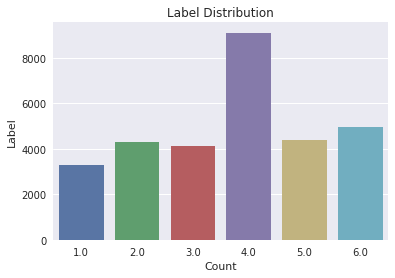

In [13]:
sns.countplot(x="label",data=df)
plt.title("Label Distribution")
plt.xlabel("Count")
plt.ylabel("Label")

In [14]:
df.columns[:-3]

Index(['CorAccXAccY_corr', 'CorAccXAccZ_corr', 'CorAccYAccZ_corr',
       'CorGyroXGyroY_corr', 'CorGyroXGyroZ_corr', 'CorGyroYGyroZ_corr',
       'accX_aoa', 'accX_apf', 'accX_ate', 'accX_max', 'accX_mean', 'accX_min',
       'accX_minmax', 'accX_rms', 'accX_std', 'accY_aoa', 'accY_apf',
       'accY_ate', 'accY_max', 'accY_mean', 'accY_min', 'accY_minmax',
       'accY_rms', 'accY_std', 'accZ_aoa', 'accZ_apf', 'accZ_ate', 'accZ_max',
       'accZ_mean', 'accZ_min', 'accZ_minmax', 'accZ_rms', 'accZ_std',
       'gyroX_aoa', 'gyroX_apf', 'gyroX_ate', 'gyroX_max', 'gyroX_mean',
       'gyroX_min', 'gyroX_minmax', 'gyroX_rms', 'gyroX_std', 'gyroY_aoa',
       'gyroY_apf', 'gyroY_ate', 'gyroY_max', 'gyroY_mean', 'gyroY_min',
       'gyroY_minmax', 'gyroY_rms', 'gyroY_std', 'gyroZ_aoa', 'gyroZ_apf',
       'gyroZ_ate', 'gyroZ_max', 'gyroZ_mean', 'gyroZ_min', 'gyroZ_minmax',
       'gyroZ_rms', 'gyroZ_std'],
      dtype='object')

In [18]:

#LOO-Validation on each subject
subject_list = np.unique(df['subject_id'])
y_test_all = []
y_pred_all = []
y_score_all = []
np.random.seed(44)
iterations = np.array(list(itertools.combinations(subject_list, 2)))

it_index = np.random.choice(iterations.shape[0], replace=False,size=2)

selected_model = 'CNN'
for i in it_index: # two combination of tested subjects
    
    subject = iterations[i]
    print("==================")
    print('Model tested on subjects with no : ', subject)
    df_training = df[np.logical_and(df['subject_id']!=subject[0],df['subject_id']!=subject[1] )]
    df_test = df[np.logical_or(df['subject_id']==subject[0], df['subject_id']==subject[1] )]
    print("Test set and training set proportion : ",float(df_test.shape[0])/df_training.shape[0] )
    X_test = df_test[df_test.columns[:-3]].values
    y_test = df_test['label'].values - 1 
    X_training = df_training[df_training.columns[:-3]].values
    y_training = df_training['label'].values - 1 
#     X_training, y_training = shuffle(X_training, y_training, random_state=44)

    # Calculate class weight
    class_weight = get_class_weights(y_training)

    if selected_model == "RNN":
        model = RNN_classifier(batch_size=3000, n_classes=6, training_iters=300,n_cells=2)
        X_test, y_test = model.transform_dataset(X_test, y_test)
        X_training, y_training = model.transform_dataset(X_training, y_training)
        model.fit(X_training=X_training, y_training= y_training, X_val=X_test, y_val=y_test, verbose=1, transform_data=False)
        y_pred = model.predict(X_test, transform_data=False)
        y_score = model.predict_proba(X_test, transform_data=False)
    else:
        if selected_model == "LogReg":
            model = LogisticRegression(class_weight = class_weight)
        elif selected_model == "SVM":
            model = svm.SVC( class_weight = class_weight, probability=True)
        elif selected_model == 'RForest':
            model = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight=class_weight)
        elif selected_model =='CNN':
            model = KerasClassifier(batch_size=100, n_classes=6,model = 'CNN', n_epoch=50)
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'])[a-1]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])
    plt.savefig('Figures/'+str(subject[0])+'_'+str(subject[1])+'.png')

Model tested on subjects with no :  [  1. 118.]
Test set and training set proportion :  0.044482137911935754
Build model...


ValueError: The shape of the input to "Flatten" is not fully defined (got (None, 64). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [16]:
X_training.shape

(28888, 60)

Confusion matrix, without normalization


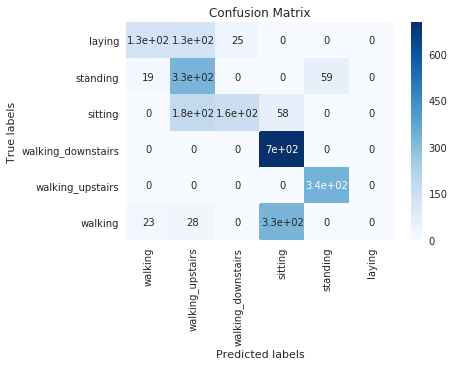

Normalized confusion matrix


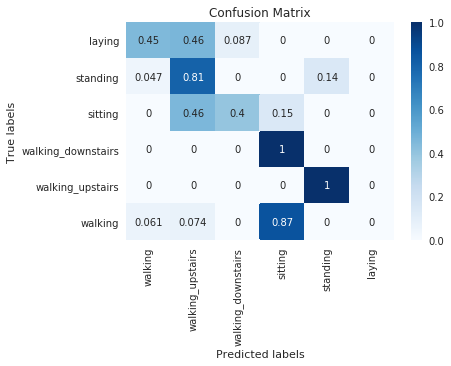

In [14]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
# plt.savefig(save_with_name+'.png')
plt.show()

In [15]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.6597609561752988


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       0.75      0.45      0.56       286
  walking_upstairs       0.49      0.81      0.61       407
walking_downstairs       0.86      0.40      0.54       399
           sitting       0.65      1.00      0.78       702
          standing       0.85      1.00      0.92       338
            laying       0.00      0.00      0.00       378

       avg / total       0.60      0.66      0.59      2510



/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

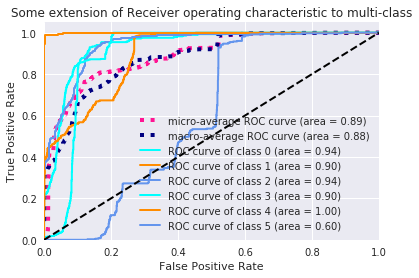

In [18]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)

## Statistical Testing of the classifiers

In [ ]:
from scipy.stats import ttest_rel

In [ ]:
asd = classification_report(y_test_all, y_pred_all,target_names=class_names)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
log_first = [0.71, 0.31, 0.64, 0.87, 0.79, 0.66]
svm = [0.64, 0.34, 0.66, 0.89, 0.73, 0.61]
log_with_l1 = [0.62, 0.50, 0.68, 0.80, 0.70, 0.69]
LSTM = [0.72, 0.64, 0.83, 0.91, 0.82, 0.75]

In [ ]:
from __future__ import print_function
print("LSTM and logistic regression",ttest_rel( LSTM, log_first))
print("SVM and logistic regression",ttest_rel( svm, log_first))
print("LSTM and SVM regression",ttest_rel( LSTM, svm))
print("Regularized logistic regression and logistic regression",ttest_rel( log_with_l1, log_first))
print("SVM and regularized logistic regression ",ttest_rel( svm, log_with_l1))
print("LSTM and  regularized logistic regression ",ttest_rel( LSTM, log_with_l1))